Load modules

In [5]:
from IPython import display

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import trimesh
import trimesh.voxel.creation
import rtree

import glob

In [2]:
from torch.utils.data import Dataset

In [3]:
import scipy.ndimage as ndimage

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [6]:
from os import listdir
from os.path import join

In [7]:
torch.set_printoptions(profile="full")

Load .obj files

In [8]:
obj_folder ='./objects/gt'
incomplete_obj_folder ='./objects/inp'

In [9]:
objects = []
for file in listdir(obj_folder):
    if file.endswith(".stl"):
        m = trimesh.load_mesh(join(obj_folder,file))
        #convert to voxels
        m_vox = trimesh.voxel.creation.voxelize(m,0.3)
        objects.append(m_vox)

incomplete_objects = []
for file in listdir(incomplete_obj_folder):
    if file.endswith(".stl"):
        m = trimesh.load_mesh(join(incomplete_obj_folder,file))
        #convert to voxels
        m_vox = trimesh.voxel.creation.voxelize(m,0.3)
        incomplete_objects.append(m_vox)

In [10]:
len(incomplete_objects)

15

Reshape tensors with padding

In [11]:
# Define size of the space (pix)
w = 32
l = 32 
h = 64 

In [12]:
def objects_to_matrices(objs):
    vox_matrices = []
    for m in objs:
        object_matrix = torch.from_numpy(m.matrix.astype(int)) # torch.ones(m.matrix.shape)
        scene_matrix = torch.zeros((l,w,h))
            
    # center the matrices in the scene
        low = (int)(scene_matrix.size(0)//2) - (int)(object_matrix.size(0)//2)
        up = low + object_matrix.size(0)
    
        low1 = (int)(scene_matrix.size(1)//2) - (int)(object_matrix.size(1)//2)
        up1 = low1 + object_matrix.size(1)
    
        low2 = (int)(scene_matrix.size(2)//2) - (int)(object_matrix.size(2)//2)
        up2 = low2 + object_matrix.size(2)
    
    
        scene_matrix[low:up,low1:up1,low2:up2] = object_matrix
        vox_matrices.append((scene_matrix))
        
    return vox_matrices
    #print(scene_matrix)
    

In [13]:
incomplete_objects[0]==objects[0]

False

In [14]:
# convert to tensors
vox_meshes = objects_to_matrices(objects)
incomplete_vox_meshes = objects_to_matrices(incomplete_objects)


In [15]:
# #show sample

# #colors = np.empty(vox_meshes[0].shape, dtype=object)
# fig = plt.figure(figsize=(6,8))
# ax = fig.gca(projection='3d')
# ax.voxels(vox_meshes[0], edgecolor='cyan')
# plt.show()

In [16]:
encoded_objects = []
for object in vox_meshes:
    layers = object[:,:,0]
    layers = layers.reshape(256,4)
    for i in range(63):
        next = object[:,:,i+1]
        next = next.reshape(256,4)
        layers = torch.cat([layers,next],1)
        
    encoded_objects.append(layers.reshape(1,256,256))
    
len(encoded_objects)

encoded_masks = []
for object in incomplete_vox_meshes:
    layers = object[:,:,0]
    layers = layers.reshape(256,4)
    for i in range(63):
        next = object[:,:,i+1]
        next = next.reshape(256,4)
        layers = torch.cat([layers,next],1)
        
    encoded_masks.append(layers.reshape(1,256,256))
    
len(encoded_objects)

15

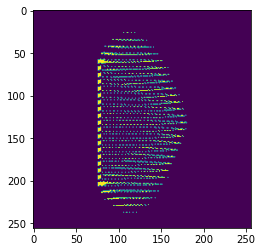

In [17]:
plt.imshow(encoded_objects[0][0])
plt.show()


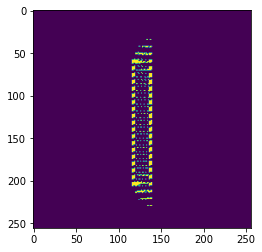

In [18]:
plt.imshow(encoded_masks[0][0])
plt.show()

In [19]:
# #inverse procedure from 2d to 3d

# c = torch.chunk(encoded_objects[0], 64, dim=1)
# chunks=[]
# for chunk in c:
#     ch = chunk.reshape(32,32)
#     chunks.append(ch)
    
# rearranged = torch.stack(chunks,2)
# #colors = np.empty(vox_meshes[0].shape, dtype=object)
# fig = plt.figure(figsize=(6,8))
# ax = fig.gca(projection='3d')
# ax.voxels(rearranged, edgecolor='cyan')
# plt.show()
# rearranged.shape
# # c1= c[1].reshape(32,32)
# # c1.shape
# # plt.imshow(c1)
# # plt.show()

In [20]:
# #show sample

# colors = np.empty(vox_meshes[0].shape, dtype=object)
# fig = plt.figure(figsize=(6,8))
# ax = fig.gca(projection='3d')
# ax.voxels(test_rearr, edgecolor='cyan')
# plt.show()

In [21]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks


        
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]        
        #x,y = self.transform(image,mask)
        return image,mask
        
    def __len__(self):
        return len(self.images)


In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
len_images=len(objects)
train_size =0.8
train_data = image_dataset(encoded_objects[:int(len_images*train_size)], encoded_masks[:int(len_images*train_size)], train=True)
train_loader = DataLoader(train_data, batch_size = 3, shuffle = True)

test_data = image_dataset(encoded_objects[int(len_images*train_size):], encoded_masks[int(len_images*train_size):], train = False)
test_loader = DataLoader(test_data, batch_size = 3, shuffle = False)

In [24]:
len(train_data)

12

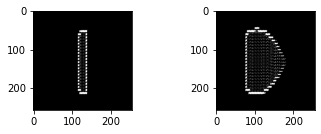

torch.Size([1, 256, 256])


In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[1][1][0],cmap ='gray')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[1][0][0],cmap ='gray')
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

networks

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [28]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
      
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))

        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
 
        x = self.out(x)
    
        return x

In [29]:
model = UNet()
model = model.to(device)
#model.apply(weights_init)
#print(model)

In [30]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# The training loop
epochs = 800
total_steps = len(train_loader)

for epoch in range(epochs):
    total_train = 0
    correct_train = 0
    for i, (images, masks) in enumerate(train_loader):
        #print(masks.shape)

        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(masks)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, images)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += images.nelement()
        correct_train += (predicted == masks).sum().item()
        train_accuracy = 100 * correct_train / total_train
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}, Accuracy:{train_accuracy}")

Epoch [1/800], Step [0/4], Loss: 0.735214, Accuracy:294.3115234375


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 4.00 GiB total capacity; 1.34 GiB already allocated; 14.31 MiB free; 1.40 GiB reserved in total by PyTorch)

In [ ]:
total_test = 0
correct_test = 0

for i, (images, masks) in enumerate(tεστ_loader):
    
#     #blur masks-2 in the batch
#     masks[0] = torch.from_numpy(gaussian_filter(masks[0],10))
#     masks[1] = torch.from_numpy(gaussian_filter(masks[1],1))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    
    masks = masks.to(device)
    images = images.to(device)
    output = model(masks)
    softmax = torch.nn.functional.log_softmax(output, dim=1)
    loss = criterion(output, images)
   
    print("loss:", loss)
    
     # accuracy
    _, predicted = torch.max(output.data, 1)
    total_test += images.nelement()
    correct_test += (predicted == masks).sum().item()
    test_accuracy = 100 * correct_train / total_train
    print("test accuracy:", test_accuracy)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()),cmap = 'gray')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
    
    plt.show()

### Training

In [ ]:
myModel = adversarialModel(num_epochs=500, samples=3, batch=3, betas=(0.5,0.5),
          g_lr=0.002, d_lr=0.001, size=32, lat_vec =200,data_path='output/models/', transforms=None)

In [ ]:
myModel.train() #reaaaaally bad results :) 

In [ ]:
some_noise = make_noise(1, 200)
some_noise = some_noise.cuda()
samples = myModel.generator(some_noise).cpu().data.numpy()

In [ ]:
image = np.squeeze(samples,0)
positive = image.__ge__(0.1)
positive

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
vox_to_display = myModel.fake_data.cpu().data.squeeze().numpy()
vox_to_display[0] 

In [ ]:
#I CAN FIND THE POSITIONS OF THE NON-ZERO ELEMENTS...CAN I USE THIS?

#get the values > number
voxels = image.__ge__(0.5)
fig = plt.figure(figsize=(32, 16))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.05, hspace=0.05)

print(voxels.shape)
#print(voxels)
for i, sample in enumerate(voxels):
        #print(sample.shape)
        s = sample.nonzero()#.reshape([3,27000])
        #print(s)
        x,y,z = s
        
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        fig = plt.figure()
        fig.set_size_inches(18.5, 16.5)
        ax = fig.gca(projection='3d')
        ax.voxels(voxels.squeeze())#, edgecolor='cyan')
        #ax.set_aspect('equal')
#plt.savefig(path + '{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
#plt.close()


#print(test_vox[0].shape)
#v=test_vox[0].squeeze()#.reshape([3,8000])
#print(v.shape)
#ax.voxels(v)
#plt.show()